## AI-HDX prediction
The Colab ipynb allows users to execute the AI-HDX model online with your own protein sequence. This version accepts one protein sequence at a time. 
### Data pre-processing
Two inputs tables are required to run this program and please follow the [data pre-processing](https://github.com/joshuayuanlab151/Seq2HDX) to prepare your input tables. 

Two input tables.       


*   Embedding vector `protein.vector.txt`. Each row contains the embedding features of one amino acid in a protein. The amino acid position and protein length should be the same as what you use to create peptide fragments.
```
1       A       0.7358490566037735      -0.617314295    -1.089185948    -0.926272767    1.486725101     0.24679532899999998     7.09302729861882        10.0    9.28971707501478        9.337021486478037             10.0    7.365279704347391       10.0    10.0    10.0    10.0    10.0    10.0    10.0    8.783609968943882       10.0    7.280002015999065       8.450115895665682       10.0    10.0    10.0    5.964030583209426     7.146344167107368       8.065895013134284       6.170392186585261       6.279658184901517       10.0    10.0    7.604230019887311       6.271477663131956       5.0
2       S       0.823076923076923       0.026690504     0.97089611      -0.8436740090000001     0.9963095740000001      0.110544377     8.297702697724748       10.0    6.73267295119654        9.343798356658402     10.0    8.271411511314541       9.621667708642791       10.0    9.737630684887721       10.0    10.0    7.6932434097818 9.371150975102958       10.0    9.262866621926072       8.392960968875936             9.407270507272811       10.0    10.0    10.0    5.217362915633222       8.43036902195414        9.511538377416292       5.693010435855571       6.942363401080304       5.430183807243099       7.532460039491867     9.329241605105182       6.326262306609193       6.256265970868344
3       I       0.15384615384615385     -1.261786099    -0.592097155    1.012212402     0.45251484799999997     0.025312684     9.693799019988838       10.0    9.05979173309898        9.714463147834625             9.6272697565057 5.7077161189449175      9.870099956354897       8.809020315885116       9.855570413443004       9.518001877443082       10.0    9.003841305264624       9.35354070409281        8.997094134840536     10.0    9.645657796146146       9.162919586743056       9.743193166062767       10.0    10.0    5.021249872058216       9.751200904332315       9.764201398332677       6.05515425456685              6.409523482283048       5.589742145184536       7.146344167107368       9.311826787372903       6.238683139895791       6.248064744684293
```

*   List item `peptide fragments.csv`. Save the peptide fragments into a .csv file with start position, stop position, sequence like this:
```
8,21,DSASSPPYSVNQNL
8,21,DSASSPPYSVNQNL
34,45,YVDKLSSSGASW
34,45,YVDKLSSSGASW
46,60,HTEWTWSGGEGTVKS
46,68,HTEWTWSGGEGTVKSYSNSGVTF
```

Now we are ready to run AI-HDX!

### Download pre-trained models and confidence index score
Ten deep learning models trained by 10 different sets of training data which are randomly split 10 times from the same database. The 10 models will predict HDX rates independently and compute an average HDX rate and a standard deviation for each peptide fragment. A confidence index score which estimates the confidence of the prediction is assigned based on the average predicted HDX rate. 

In [ ]:
## Download the models from github repo
%%bash
wget https://github.com/Environmentalpublichealth/AI-HDX/raw/main/models.zip
unzip /content/models.zip

In [ ]:
## Load the pre-trained Neural Network models
import tensorflow as tf
root_dir = '/home/lwang/AI-HDX-main/models'
model1 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m1")
model2 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m2")
model3 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m3")
model4 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m4")
model5 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m5")
model6 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m6")
model7 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m7")
model8 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m8")
model9 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m9")
model10 = tf.keras.models.load_model(f"{root_dir}/NNmodel_m10")

In [4]:
## Load the pre-trained confidence index score based on the error rate between predictions and ground true in validation sets
confidx = [0.435003467810392,0.584915875217703,0.691762575882027,0.707836210244849,0.626804716837474,0.591011203879881,0.532705643129479,0.426545116775042,0.251348832172361,0.36508649008649]

In [ ]:
import os
import pandas as pd
import torch
from pepGraph_basemodel_training import base_data, test_basemodel
import tensorflow as tf

##################################### initial setting ##################################### 
root_dir = "/home/lwang/AI-HDX-main/HDX_MS_dataset/complexpair_dataset"
HDX_summary_file = f'{root_dir}/merged_complex_pair.xlsx'
hdx_df = pd.read_excel(HDX_summary_file, sheet_name='Sheet1')
hdx_df = hdx_df.dropna(subset=['chain_identifier'])

dssp_dir = os.path.join(root_dir, 'dssp_files')
hhm_dir = os.path.join(root_dir, 'hhm_files')
rigidity_dir = os.path.join(root_dir, 'rigidity_files')
proflex_dir = os.path.join(root_dir, 'proflex_files')
embedding_dir = os.path.join(root_dir, 'embedding_files')
HDX_dir = os.path.join(root_dir, 'HDX_files')

result_dir = '/home/lwang/models/HDX_LSTM/results/temp_basemodel'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
##################################### initial setting ##################################### 
    
device = torch.device('cpu')
print(device)

### data preparation ###
input_data, truth_data = base_data(hdx_df, root_dir)
print('length of input_data:', len(input_data))
input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
truth_data = tf.convert_to_tensor(truth_data, dtype=tf.float32)

In [12]:
print('input_data shape:', input_data.shape)
print('truth_data shape:', truth_data.shape)

trim_input_data = tf.concat((input_data[:, 0:6, :], input_data[:, 16:46, :]), axis=1)
print('trim_input_data shape:', trim_input_data.shape)
trim_input_data = tf.permute(trim_input_data, [0, 2, 1])

input_data shape: (1302, 47, 30)
truth_data shape: (1302,)
trim_input_data shape: (1302, 36, 30)


### Run AI-HDX prediction
The script takes the 10 pre-trained models and predict 10 HDX rates for each peptide. An average HDX rate and a standard deviation of predicted HDX rate is computed and output into a new data frame. A confidence score to estimate the prediction confidence is calculated for each peptide and output to the data frame.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# get predictions from the 10 models randomly trained by different training sets and validation sets
x_test = tf.reshape(trim_input_data, [trim_input_data.shape[0], 30, 36])
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]
colnames = ["model1","model2","model3","model4", "model5","model6","model7","model8","model9", "model10"]
out_pred = []
for idx, model in enumerate(models):
  y_pred = model.predict(x_test)
  out_pred.append(y_pred)

out_df = np.concatenate(out_pred, axis=1)
print(out_df.shape)

PCC: 0.07469930938923834


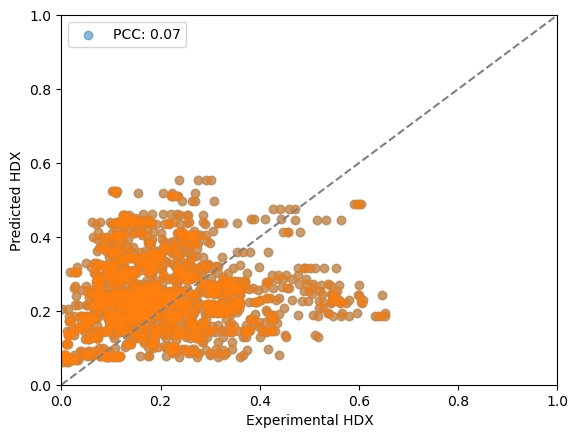

In [16]:
mean_pred = np.mean(out_df, axis=1)

pcc = pearsonr(truth_data, mean_pred)
print('PCC:', pcc[0])

### plot ###
plt.figure()
plt.scatter(truth_data, mean_pred, alpha=0.5)
plt.xlabel('Experimental HDX')
plt.ylabel('Predicted HDX')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], '--', color='gray')  # Add diagonal dashed line
plt.scatter(truth_data, mean_pred, alpha=0.5)
plt.xlabel('Experimental HDX')
plt.ylabel('Predicted HDX')
plt.legend(['PCC: {:.2f}'.format(pcc[0])])
plt.show()

In [ ]:
# calculate average prediction values(mean) and standard deviation(SD)
out_df["average"] = out_df[colnames].mean(axis=1)
out_df["SD"] = out_df[colnames].std(axis=1)

# add CI score to each prediction
def pred_range(a):
  for i in range(0,10):
    if a >i*0.1 and a <= (i+1)*0.1:
      CI = confidx[i]
      return CI
scores=[]
for idx, pred in enumerate(out_df["average"]):
  conf_score = pred_range(pred)
  scores.append(conf_score)
  
out_df["CI"]=np.array(scores) 